In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50), nn.ReLU(), 
            nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(50, 1) 
        )

    def forward(self, x):
        return self.hidden_layers(x)


model = PINN()


In [13]:
def black_scholes_loss(model, X):
    
    X.requires_grad = True  
    u_pred = model(X)  

    grads = torch.autograd.grad(u_pred.sum(), X, create_graph=True)[0]
    u_t, u_s = grads[:, 0:1], grads[:, 1:2]

   
    grads2 = torch.autograd.grad(u_s.sum(), X, create_graph=True)[0]
    u_ss = grads2[:, 1:2]

   
    sigma = 0.4 
    r = 0.03

   
    f_pred = u_t + 0.5 * sigma**2 * X[:, 1:2]**2 * u_ss + (r * X[:, 1:2] * u_s) - r * u_pred
    loss = torch.mean(f_pred**2)  

    return loss

In [25]:
import numpy as np


N_f = 100000  
t_samples = torch.rand(N_f, 1) * 3 
S_samples = torch.rand(N_f, 1) * 500 
X_f = torch.cat((t_samples, S_samples), dim=1)  

tensor([[319.8167],
        [374.6143],
        [ 81.3767],
        ...,
        [236.6887],
        [287.9724],
        [464.9474]])


In [26]:
optimizer = optim.Adam(model.parameters(), lr=0.005)  
epochs = 50

for epoch in range(epochs):
    optimizer.zero_grad()  
    loss = black_scholes_loss(model, X_f)  
    loss.backward()  
    optimizer.step() 
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 0.000000
Epoch 5: Loss = 0.000003
Epoch 10: Loss = 0.000012
Epoch 15: Loss = 0.000008
Epoch 20: Loss = 0.000004
Epoch 25: Loss = 0.000001
Epoch 30: Loss = 0.000000
Epoch 35: Loss = 0.000001
Epoch 40: Loss = 0.000001
Epoch 45: Loss = 0.000001


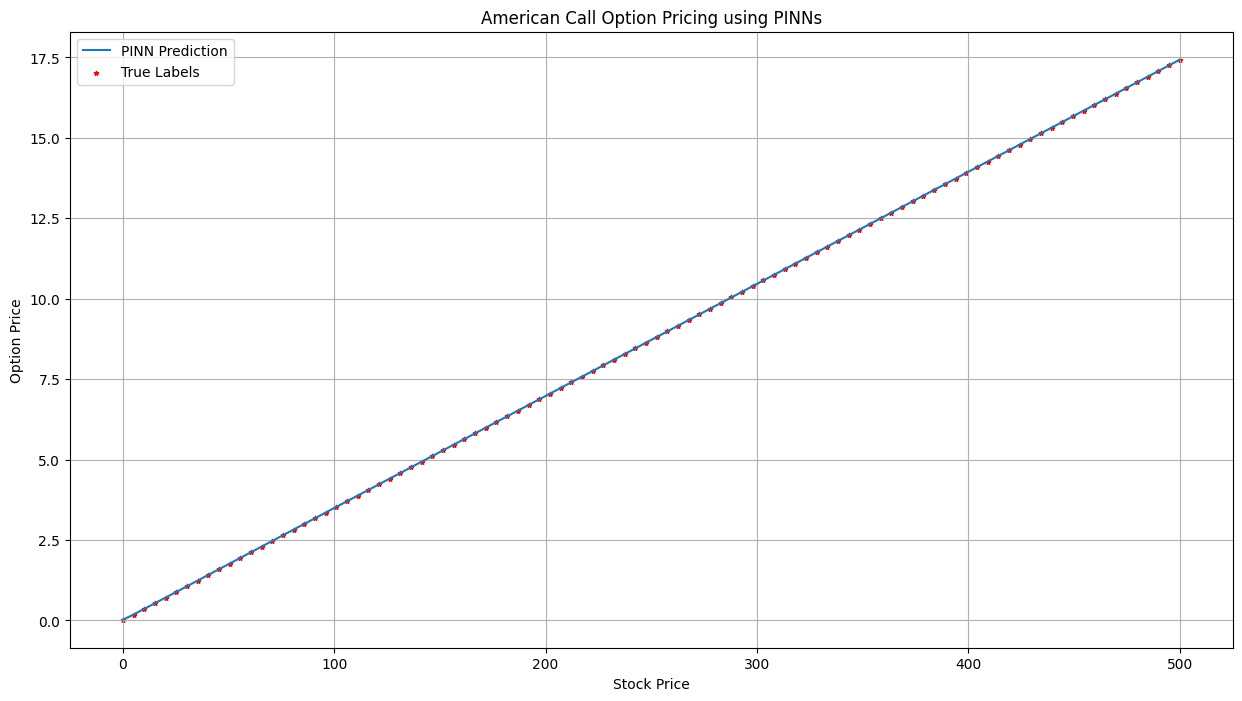

In [36]:
import matplotlib.pyplot as plt


S_test = torch.linspace(0, 500, 100).reshape(-1, 1) 
t_test = torch.full_like(S_test, 1.5)  

X_test = torch.cat((t_test, S_test), dim=1)
C_pred = model(X_test).detach().numpy()


plt.figure(figsize=(15,8))
plt.plot(S_test.numpy(), C_pred, label="PINN Prediction")
plt.scatter(S_test,C_pred,s=10,marker='*',color='red',label='True Labels')
plt.xlabel("Stock Price")
plt.ylabel("Option Price")
plt.title("American Call Option Pricing using PINNs")
plt.legend()
plt.grid()
plt.show()